In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_formated_region_coords, rotate_region
from classifier2 import classify_masks,visualize_classifications
from pca import get_pcs, get_variance_direction
from plot import plot_pcs
from projection import upper_lower
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sub_segmentation import (
    subsegment_region,
    visualize_subsegments,
    subsegment_region_y_axis,
)
from determine_line import ( get_cellbody_center,
    get_line,
    remove_outliers,
    best_fit_polynomial,
    align_regions
    )

In [2]:
p0 = r"..\..\tests\data\combined_mean_image1_seg.npy"
masks = np.load(p0, allow_pickle=True).item()["masks"]
# plt.figure(figsize=(20, 10))
# plt.imshow(masks)
# plt.gca().invert_yaxis()
# plt.show()

In [3]:

classifications, body, processes, body_and_processes = classify_masks(masks)
# visualize_classifications(masks=masks, classifications=classifications)
# plt.gca().invert_yaxis()

upper, lower = body_and_processes['upper'], body_and_processes['lower']


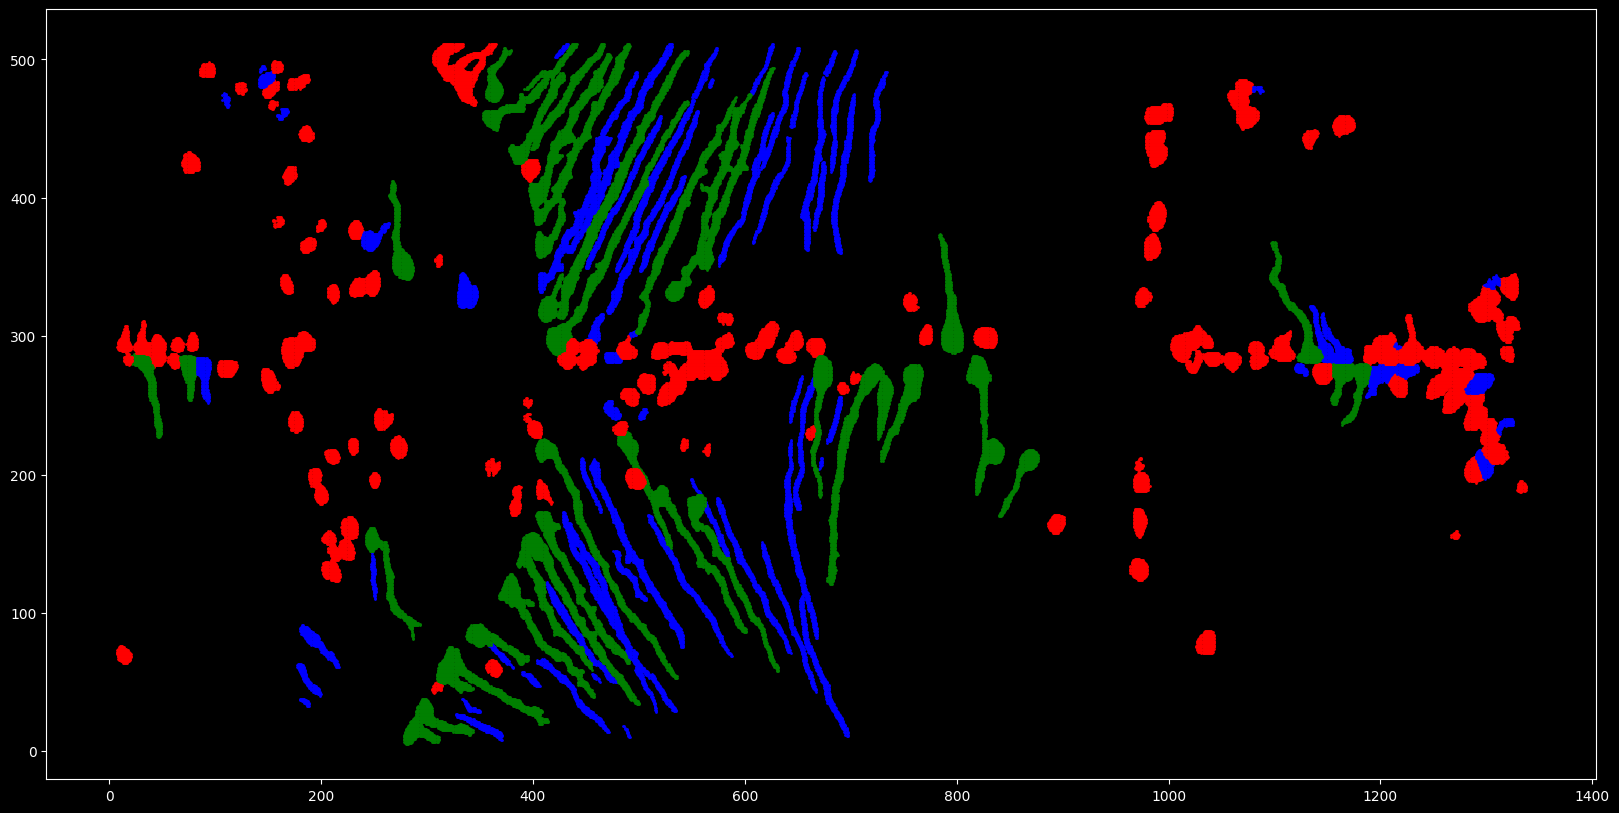

In [4]:
plt.figure(figsize=(20, 10))
visualize_classifications(masks=masks, classifications=classifications)
plt.show()

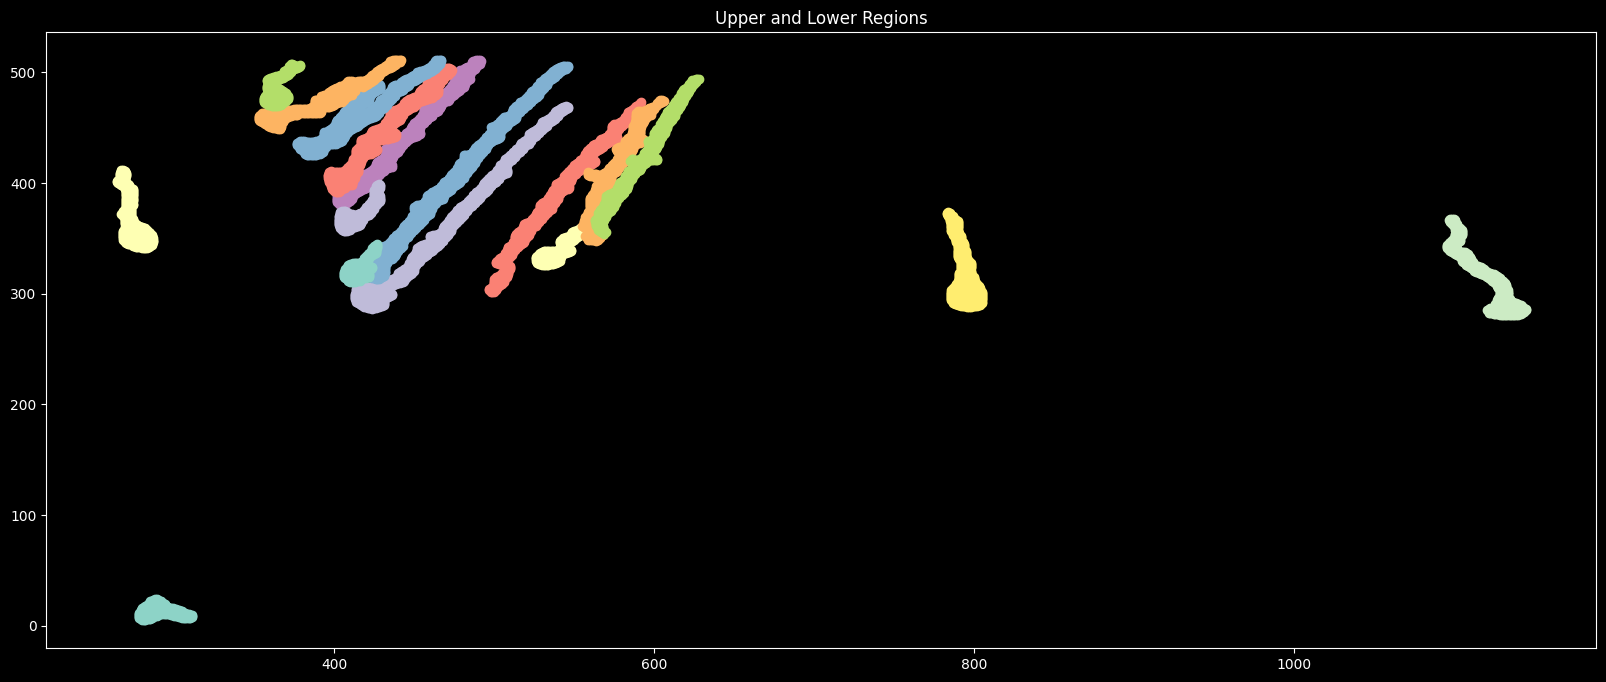

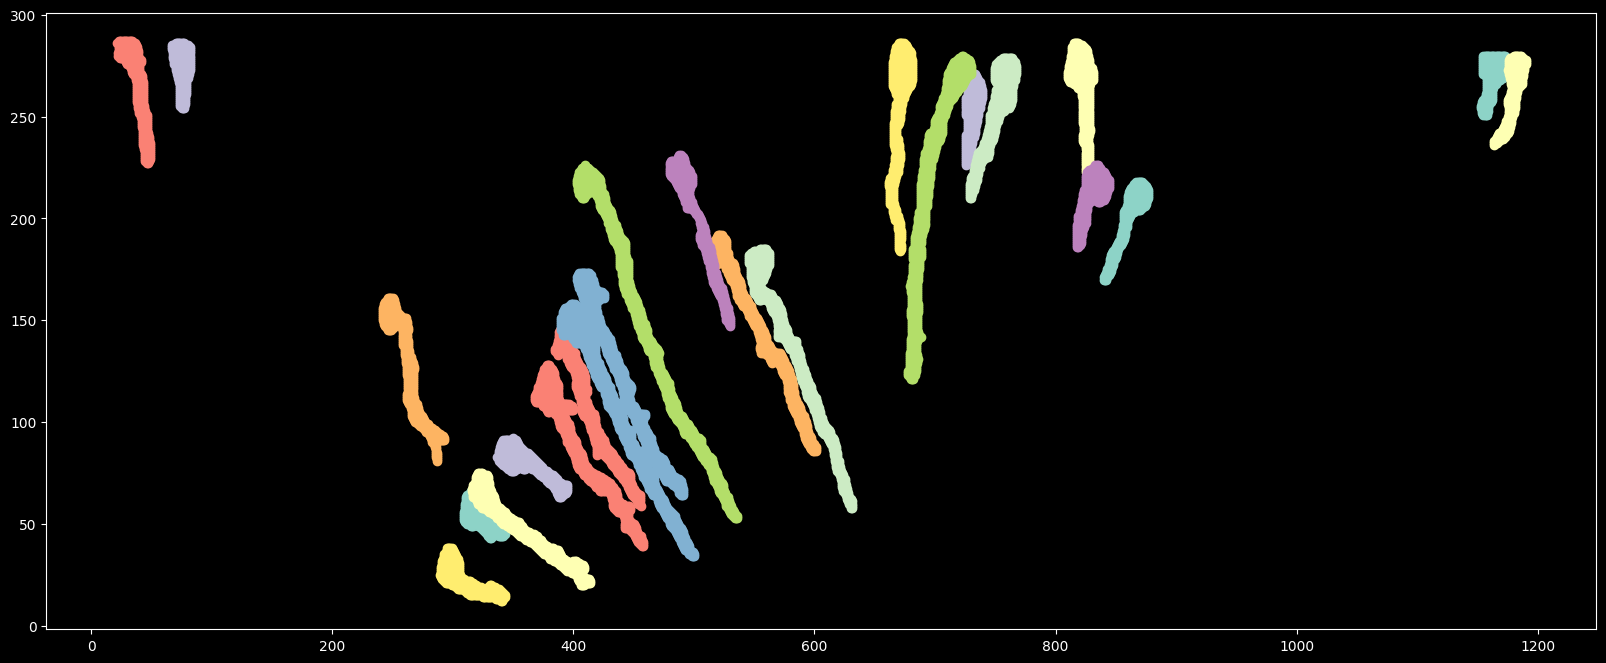

In [5]:
# Plot upper and lower regions

fig, ax = plt.subplots(figsize=(20, 8))

# Plot upper regions
ax.set_title('Upper and Lower Regions')
for label in upper:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    ax.scatter(region[:, 0], region[:, 1])

plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
# Plot lower regions
for label in lower:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    ax.scatter(region[:, 0], region[:, 1])
plt.show()
# line_label, body = get_line(upper, masks,True)

# line = np.array([x[0] for x in line_label])
# line = np.array(line)
# sorted_indices = np.argsort(line[:, 0])
# line = line[sorted_indices]

# best_degree, best_r_score, best_mse, best_coefficients = best_fit_polynomial(line)

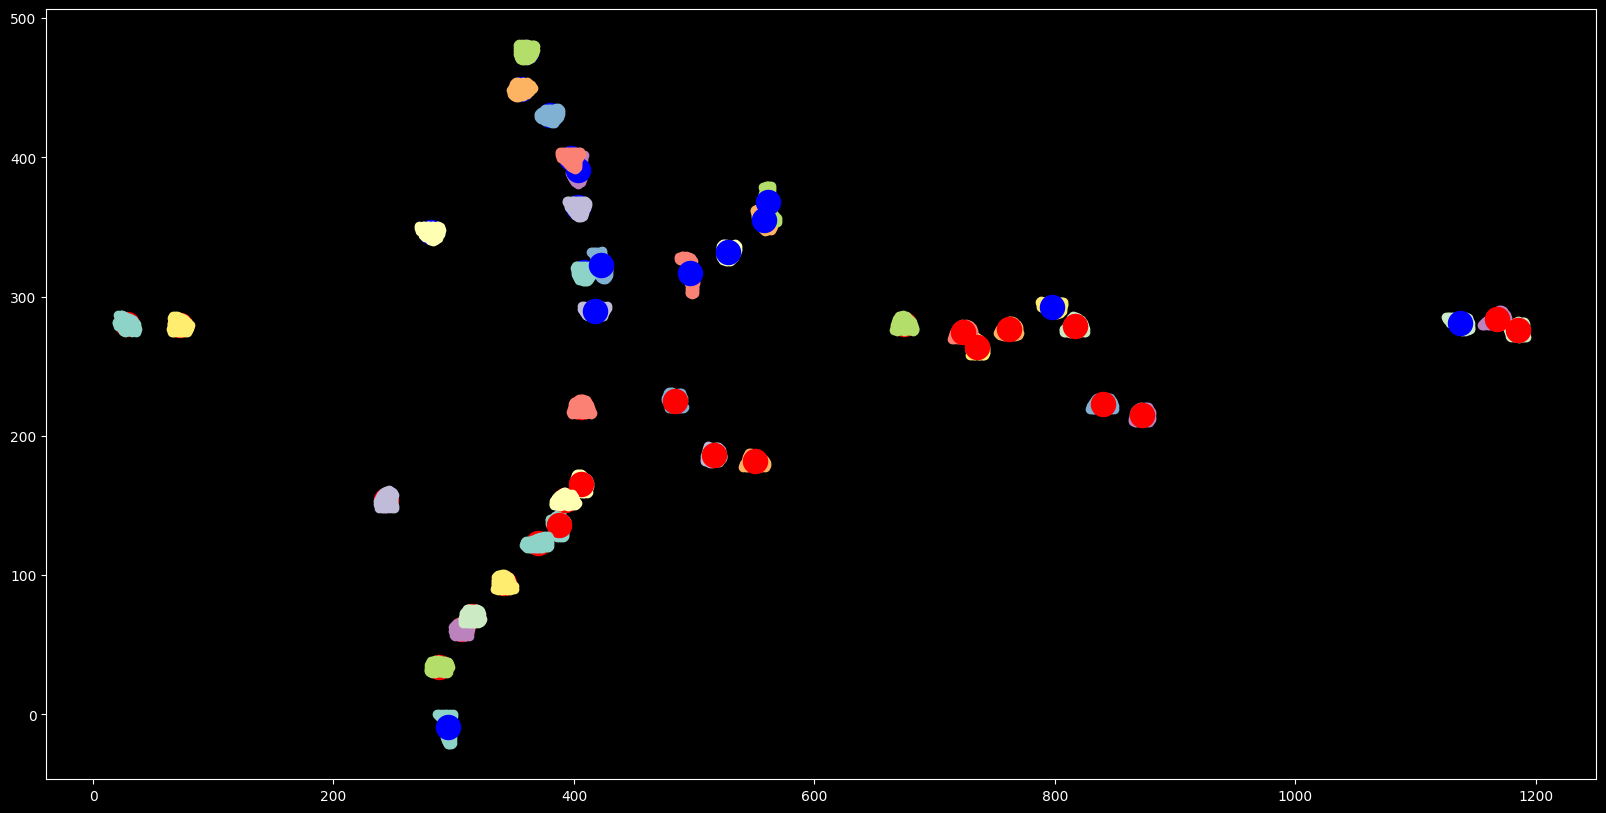

In [6]:
line_upper, body_upper = get_line(upper, masks,True)
line_lower, body_lower = get_line(lower, masks,False)

plt.figure(figsize=(20, 10))

for i in range(len(line_upper)):
    plt.scatter(body_upper[i][:, 0], body_upper[i][:, 1])

    plt.scatter(line_upper[i][0][0], line_upper[i][0][1], c='b', s=300)


for i in range(len(line_lower)):
    plt.scatter(body_lower[i][:, 0], body_lower[i][:, 1])
    plt.scatter(line_lower[i][0][0], line_lower[i][0][1], c='r', s=300)


plt.show()

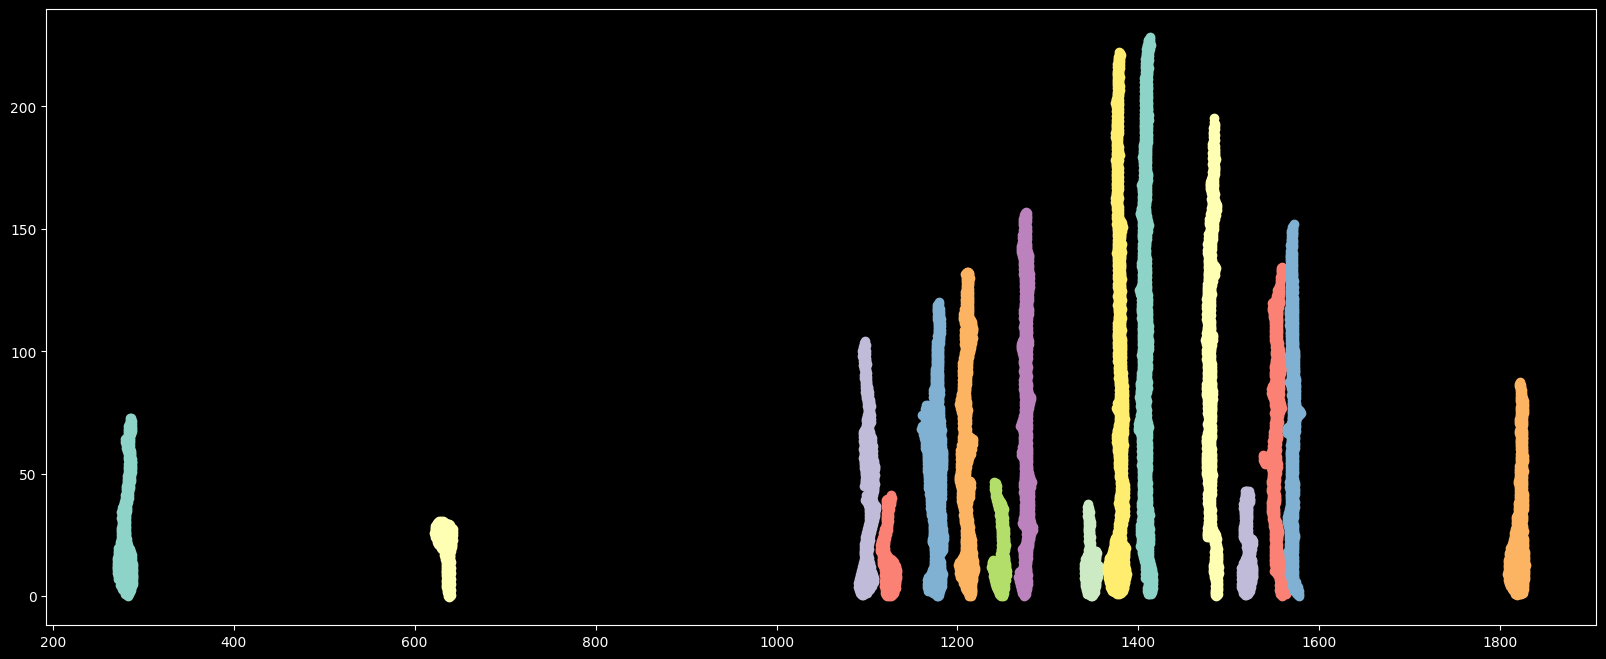

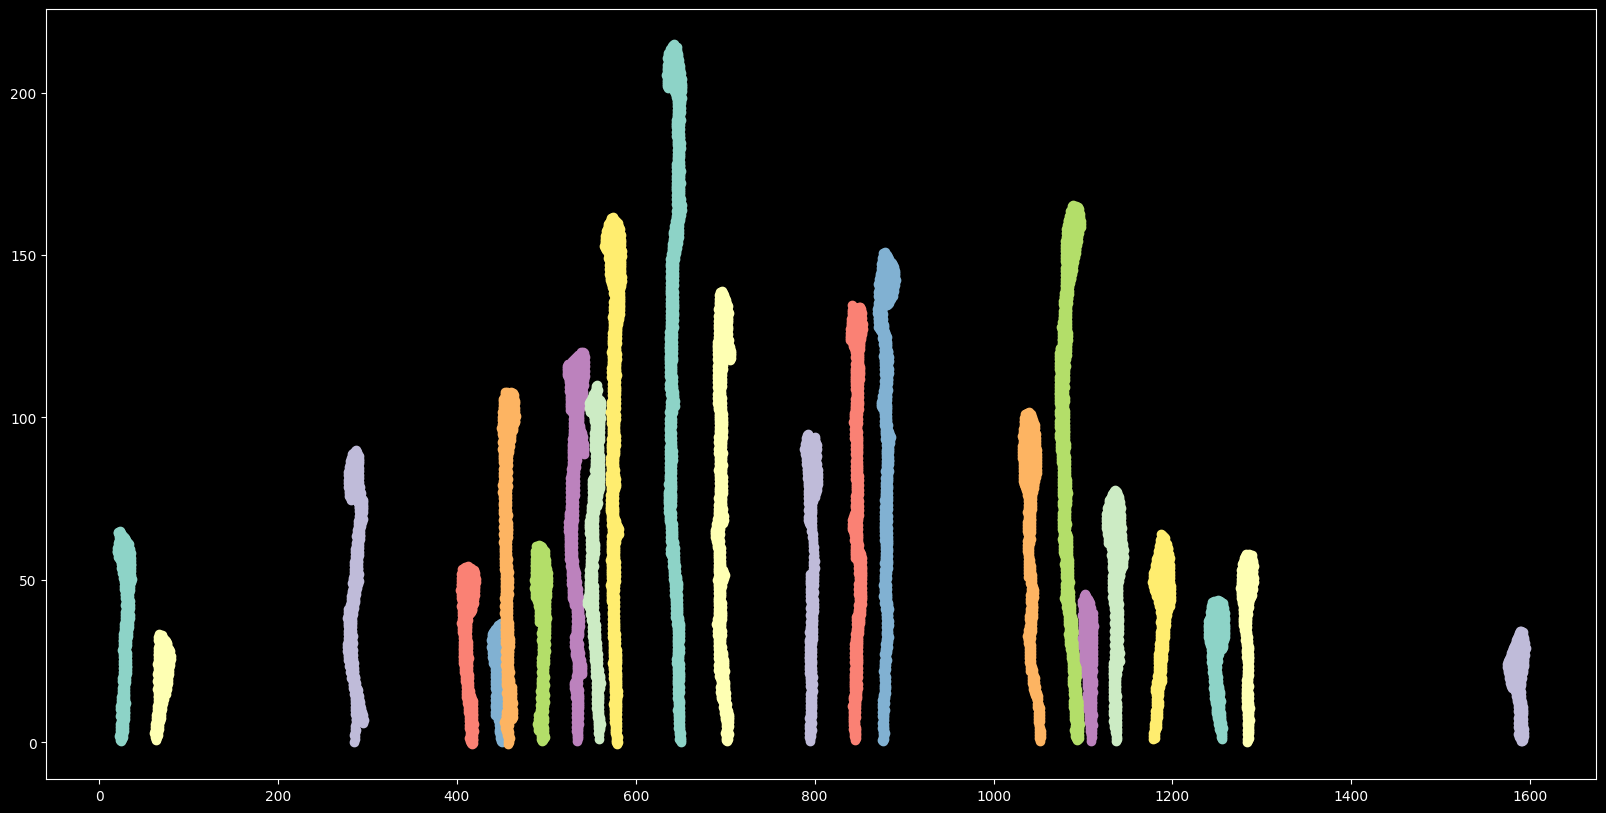

In [7]:
aligned_upper = align_regions(line_upper, masks, True)
aligned_lower = align_regions(line_lower, masks, False)

plt.figure(figsize=(20, 8))

for i in range(len(aligned_upper)):
    plt.scatter(aligned_upper[i][:, 0], aligned_upper[i][:, 1])

# for i in range(len(aligned_lower)):
#     plt.scatter(aligned_lower[i][:, 0], aligned_lower[i][:, 1])

plt.show()

plt.figure(figsize=(20, 10))

# for i in range(len(aligned_upper)):
#     plt.scatter(aligned_upper[i][:, 0], aligned_upper[i][:, 1])

for i in range(len(aligned_lower)):
    plt.scatter(aligned_lower[i][:, 0], aligned_lower[i][:, 1])

plt.show()